In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

from statsmodels.formula.api import ols

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam, Adamax

from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
#aa = "A01"
#aa = "A02"
#aa = "A03"
#aa = "A04"
#aa = "A05"
aa = "A06"
A0=pd.read_csv(aa+".csv",encoding="utf-8-sig")

In [3]:
A0["de_dt"] = pd.to_datetime(A0["de_dt"].astype(int).astype(str))
A0

,cust,pd_c,cop_c,de_dt,de_hr,buy_am,ma_fem_dv,ages,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M466487936,PD0390,A06,2021-01-01,16,1000.0,여성,40대,쌈/또띠아,대용식,건면
1,M552902613,PD1776,A06,2021-01-01,0,157000.0,여성,40대,여성펌프스,패션잡화,여성화
2,M102283139,PD1022,A06,2021-01-01,0,32900.0,여성,40대,피규어,완구,남아완구
3,M803112421,PD1889,A06,2021-01-01,0,54000.0,여성,30대,BB/파운데이션/컴팩트류,화장품/뷰티케어,메이크업
4,M803112421,PD1893,A06,2021-01-01,0,34000.0,여성,30대,마스카라,화장품/뷰티케어,메이크업
...,...,...,...,...,...,...,...,...,...,...,...
76243,M533286446,PD0507,A06,2021-12-31,23,50000.0,남성,40대,백화점/마트모바일상품권,상품권,모바일상품권
76244,M533286446,PD0507,A06,2021-12-31,23,50000.0,남성,40대,백화점/마트모바일상품권,상품권,모바일상품권
76245,M533286446,PD0507,A06,2021-12-31,23,50000.0,남성,40대,백화점/마트모바일상품권,상품권,모바일상품권
76246,M533286446,PD0507,A06,2021-12-31,23,50000.0,남성,40대,백화점/마트모바일상품권,상품권,모바일상품권


# 전처리

## 점수 base 생성

In [4]:
#raitings : 고객 별 상품 구매 횟수 count (대분류는 덤으로!)
A0_tmp = A0.value_counts(['cust','pd_c',"de_dt","clac_mcls_nm","clac_hlv_nm"]).reset_index().rename(columns={0:"buy_am"})
ratings=A0_tmp.groupby(['cust','pd_c',"clac_mcls_nm","clac_hlv_nm"],as_index=False).count()[['cust','pd_c',"clac_mcls_nm","clac_hlv_nm",'buy_am']]
ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am
0,M000136117,PD0290,남성의류상의,남성의류,1
1,M000136117,PD0611,화장지/티슈,세제/위생,1
2,M000136117,PD0613,화장지/티슈,세제/위생,1
3,M000136117,PD0614,화장지/티슈,세제/위생,1
4,M000136117,PD0899,조리기구,식기/조리기구,1
...,...,...,...,...,...
44783,M999599111,PD0539,이미용가전,생활/주방가전,1
44784,M999962961,PD0954,여성의류상의,여성의류,1
44785,M999962961,PD0959,여성의류아우터,여성의류,1
44786,M999962961,PD0967,여성의류하의,여성의류,1


In [5]:
#고객 별 상품 대분류 별 구매 횟수
tmp = A0_tmp.groupby(['cust','clac_hlv_nm'],as_index=False).count()[['cust','clac_hlv_nm','buy_am']]
tmp

,cust,clac_hlv_nm,buy_am
0,M000136117,남성의류,1
1,M000136117,세제/위생,3
2,M000136117,식기/조리기구,1
3,M000136117,여성의류,1
4,M000136117,주방잡화,2
...,...,...,...
29726,M999268192,상품권,18
29727,M999268192,테넌트/음식점,1
29728,M999599111,생활/주방가전,1
29729,M999962961,여성의류,3


In [6]:
#고객 별 구매 횟수
tmp_ref = A0_tmp.groupby("cust",as_index=False).sum()[["cust","buy_am"]].rename(columns={"buy_am":"buy_sum"})
tmp_ref

,cust,buy_sum
0,M000136117,10
1,M000494848,11
2,M000621637,21
3,M000986912,6
4,M001086020,1
...,...,...
7695,M999105944,2
7696,M999180761,1
7697,M999268192,24
7698,M999599111,1


In [7]:
#참조1 : 고객 별 대분류 구매 비율 생성

ref1 = pd.merge(tmp,tmp_ref, how='left',on='cust')
ref1["buy_score_ref"] = ref1["buy_am"]/ref1["buy_sum"]
ref1 = ref1.drop(["buy_am","buy_sum"],axis=1)
ref1

,cust,clac_hlv_nm,buy_score_ref
0,M000136117,남성의류,0.100000
1,M000136117,세제/위생,0.300000
2,M000136117,식기/조리기구,0.100000
3,M000136117,여성의류,0.100000
4,M000136117,주방잡화,0.200000
...,...,...,...
29726,M999268192,상품권,0.750000
29727,M999268192,테넌트/음식점,0.041667
29728,M999599111,생활/주방가전,1.000000
29729,M999962961,여성의류,0.750000


In [8]:
#참조2 : 고객 별 상품 별 마지막 구매 날짜
score_update=A0_tmp.value_counts(['cust','pd_c','de_dt']).reset_index()[['cust','pd_c','de_dt']]
ref2 = score_update.groupby(["cust","pd_c"],as_index=False).max("de_dt").rename(columns={"de_dt":"last_dt"})
ref2

,cust,pd_c,last_dt
0,M000136117,PD0290,2021-03-06
1,M000136117,PD0611,2021-01-04
2,M000136117,PD0613,2021-01-04
3,M000136117,PD0614,2021-02-22
4,M000136117,PD0899,2021-01-11
...,...,...,...
44783,M999599111,PD0539,2021-01-31
44784,M999962961,PD0954,2021-01-22
44785,M999962961,PD0959,2021-01-13
44786,M999962961,PD0967,2021-04-06


In [9]:
#참조3 : 상품 별 고객 마다의 구매 간격들 평균 

tmp = A0_tmp.value_counts(['cust','pd_c','de_dt'])
date_file = tmp.reset_index()[['cust','pd_c','de_dt']]

qq = date_file.value_counts(["cust","pd_c"])[date_file.value_counts(["cust","pd_c"]) > 1].reset_index()[['cust','pd_c']]
qq

range_lst = []
for n in tqdm_notebook(range(len(qq))):
    i = qq.loc[n,"cust"]
    j = qq.loc[n,"pd_c"]
    tmp = date_file[(date_file["pd_c"] == j)&(date_file["cust"] == i)].sort_values("de_dt")
    for k in range(len(tmp)-1):
        range_lst.append({"pd_c":j,"range_mean":(tmp.iloc[k+1,2] - tmp.iloc[k,2]).days})
range_lst = pd.DataFrame(range_lst)

ref3 = range_lst.groupby("pd_c",as_index=False).mean("range_mean")[["pd_c","range_mean"]]

<ipython-input-9-5d7e158bef0e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(qq))):


  0%|          | 0/6806 [00:00<?, ?it/s]

In [10]:
#합쳐주기!
ratings = pd.merge(ratings,ref1, how='left',on=['cust',"clac_hlv_nm"])
ratings = pd.merge(ratings,ref2, how='left',on=['cust',"pd_c"])
ratings = pd.merge(ratings,ref3, how='left',on='pd_c')
ratings = ratings.fillna(0)

ratings

,cust,pd_c,clac_mcls_nm,clac_hlv_nm,buy_am,buy_score_ref,last_dt,range_mean
0,M000136117,PD0290,남성의류상의,남성의류,1,0.10,2021-03-06,40.630137
1,M000136117,PD0611,화장지/티슈,세제/위생,1,0.30,2021-01-04,62.812500
2,M000136117,PD0613,화장지/티슈,세제/위생,1,0.30,2021-01-04,55.346154
3,M000136117,PD0614,화장지/티슈,세제/위생,1,0.30,2021-02-22,59.500000
4,M000136117,PD0899,조리기구,식기/조리기구,1,0.10,2021-01-11,43.750000
...,...,...,...,...,...,...,...,...
44783,M999599111,PD0539,이미용가전,생활/주방가전,1,1.00,2021-01-31,10.200000
44784,M999962961,PD0954,여성의류상의,여성의류,1,0.75,2021-01-22,72.126582
44785,M999962961,PD0959,여성의류아우터,여성의류,1,0.75,2021-01-13,52.258065
44786,M999962961,PD0967,여성의류하의,여성의류,1,0.75,2021-04-06,48.462838


## 점수체계

In [11]:
#구매 횟수 0~5점
ratings['buy_level']=np.where(ratings.buy_am>=24,5,
                       np.where(ratings.buy_am>=12,4,
                               np.where(ratings.buy_am>=6,3,
                                       np.where(ratings.buy_am>=4,2,
                                               np.where(ratings.buy_am>=3,1,0)))))

ratings['buy_level']=ratings['buy_level'].astype('float')

In [12]:
#대분류 0~5점

low_clac_lst = A0_tmp.value_counts(["cust","clac_hlv_nm"]).reset_index().rename(columns={0:"count"}).groupby("clac_hlv_nm",as_index=False).mean("count")[["clac_hlv_nm","count"]]

low_clac_lst["low_clac"] = np.where(low_clac_lst["count"] >= low_clac_lst["count"].quantile(q=15/21),5,
                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=10/21),4,
                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=6/21),3,
                                       np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=3/21),2,
                                               np.where(low_clac_lst["count"]>=low_clac_lst["count"].quantile(q=1/21),1,0)))))


ratings = pd.merge(ratings, low_clac_lst.drop("count",axis=1), how='left',on = 'clac_hlv_nm')

In [13]:
#(구매 간격 / 평균 구매 간격)의 quantile 별 점수

##range_mean이 0인 애들의 대체값, 같은 대분류들 중 최대 구매간격
tmp_value = ratings[ratings["range_mean"] == 0].value_counts("clac_hlv_nm").reset_index().drop(0,axis=1)
tmp_m = []
for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):
    tmp_m.append(ratings[(ratings["clac_hlv_nm"] == i) & (ratings["range_mean"] != 0)]["range_mean"].max())
tmp_value["tmp_m"] = tmp_m

ratings = pd.merge(ratings, tmp_value, how='left',on="clac_hlv_nm")
ratings.loc[ratings["range_mean"] != 0,"tmp_m"] = 0
ratings["tmp_m"] = ratings["tmp_m"].fillna(ratings["range_mean"].max())

today = pd.datetime(year = 2022, month = 1, day = 1)
ratings["range_result"] = (today - ratings["last_dt"]).dt.days / (ratings["range_mean"] + ratings["tmp_m"])


ratings["range_score"] = np.where(ratings["range_result"] >= ratings["range_result"].quantile(q=15/21),5,
                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=10/21),4,
                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=6/21),3,
                                       np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=3/21),2,
                                               np.where(ratings["range_result"]>=ratings["range_result"].quantile(q=1/21),1,0)))))

<ipython-input-13-2b9e33574f74>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(tmp_value["clac_hlv_nm"]):


  0%|          | 0/56 [00:00<?, ?it/s]

<ipython-input-13-2b9e33574f74>:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(year = 2022, month = 1, day = 1)


### 비율 확인

(array([4.2296e+04, 0.0000e+00, 1.2060e+03, 0.0000e+00, 6.5500e+02,
        0.0000e+00, 4.7900e+02, 0.0000e+00, 1.2700e+02, 2.5000e+01]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

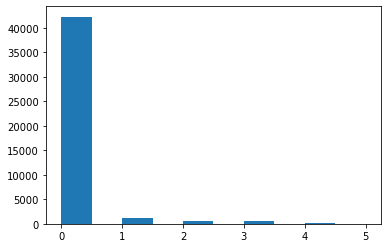

In [14]:
plt.hist(ratings["buy_level"], bins = np.arange(0,5.5,0.5))

(array([  511.,     0.,   852.,     0.,  2081.,     0.,  5085.,     0.,
         7847., 28412.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

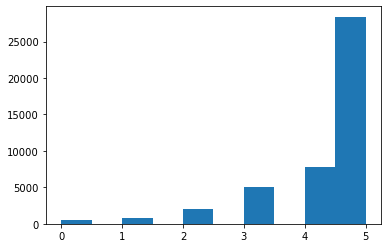

In [15]:
plt.hist(ratings["low_clac"], bins = np.arange(0,5.5,0.5))

(array([ 2133.,     0.,  4266.,     0.,  6390.,     0.,  8538.,     0.,
        10664., 12797.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

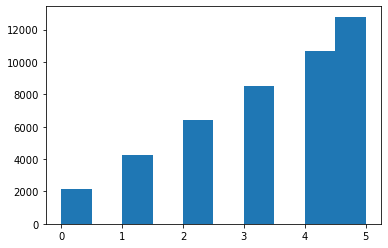

In [16]:
plt.hist(ratings["range_score"], bins = np.arange(0,5.5,0.5))

In [17]:
ratings["score"] = (ratings["buy_level"]*2 + ratings["low_clac"] + ratings["range_score"])/4

(array([2.0100e+02, 1.0110e+03, 4.6170e+03, 1.1239e+04, 1.8628e+04,
        7.9660e+03, 6.4700e+02, 3.0300e+02, 1.6000e+02, 1.6000e+01]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

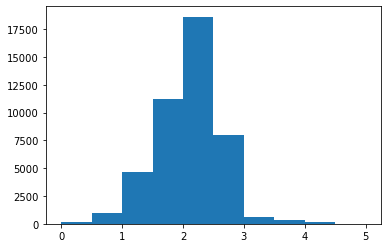

In [18]:
plt.hist(ratings["score"], bins = np.arange(0,5.5,0.5))

# 모델링

## LabelEncoding

In [19]:
le_c = LabelEncoder()
le_c = le_c.fit(ratings.cust)
ratings['cust']=le_c.transform(ratings.cust)
customer_info=pd.DataFrame(le_c.classes_, columns={'cust'})
customer_info['label']=range(0,len(ratings.cust.unique()))
customer_info.to_csv(aa+"_customer_info.csv",index=False)
customer_info

,cust,label
0,M000136117,0
1,M000494848,1
2,M000621637,2
3,M000986912,3
4,M001086020,4
...,...,...
7695,M999105944,7695
7696,M999180761,7696
7697,M999268192,7697
7698,M999599111,7698


In [20]:
le_p = LabelEncoder()
le_p = le_p.fit(ratings.pd_c)
ratings['pd_c']=le_p.transform(ratings.pd_c)
pd_info=pd.DataFrame(le_p.classes_, columns={'pd_c'})
pd_info['label']=range(0,len(ratings.pd_c.unique()))
pd_info.to_csv(aa+"_pd_info.csv",index=False)
pd_info

,pd_c,label
0,PD0001,0
1,PD0002,1
2,PD0003,2
3,PD0004,3
4,PD0006,4
...,...,...
1383,PD1928,1383
1384,PD1929,1384
1385,PD1930,1385
1386,PD1931,1386


In [21]:
# train test 분리
TRAIN_SIZE = 0.9
ratings = shuffle(ratings)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [22]:
users=A0.groupby(['cust','ages','ma_fem_dv'],as_index=False).count()
users=users[['cust','ages','ma_fem_dv']]
users['cust']=le_c.transform(users.cust)
users

,cust,ages,ma_fem_dv
0,0,30대,여성
1,1,30대,여성
2,2,40대,여성
3,3,30대,여성
4,4,50대,남성
...,...,...,...
7695,7695,30대,남성
7696,7696,30대,남성
7697,7697,30대,여성
7698,7698,40대,여성


In [23]:
ages=[]
for i in range(len(users)):
    users.ages[i]=users.ages[i][0:2]
users.ages=users.ages.astype('float')

<ipython-input-23-ab29fe5432dc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ages[i]=users.ages[i][0:2]


In [24]:
le_s = LabelEncoder()
le_s = le_s.fit(users.ma_fem_dv)
users['ma_fem_dv']=le_s.transform(users.ma_fem_dv)

customer_info['sex']=users['ma_fem_dv']
customer_info

,cust,label,sex
0,M000136117,0,1
1,M000494848,1,1
2,M000621637,2,1
3,M000986912,3,1
4,M001086020,4,0
...,...,...,...
7695,M999105944,7695,0
7696,M999180761,7696,0
7697,M999268192,7697,1
7698,M999599111,7698,1


In [25]:
users

,cust,ages,ma_fem_dv
0,0,30.0,1
1,1,30.0,1
2,2,40.0,1
3,3,30.0,1
4,4,50.0,0
...,...,...,...
7695,7695,30.0,0
7696,7696,30.0,0
7697,7697,30.0,1
7698,7698,40.0,1


In [26]:
L=len(customer_info)
train_asz = pd.merge(ratings_train, users, on='cust')[['ages','ma_fem_dv']]
test_asz = pd.merge(ratings_test, users, on='cust')[['ages','ma_fem_dv']]

## INPUT file (구매 경험이 없는 고객-상품 모음) 생성

In [27]:
ratings = pd.merge(ratings,users,how="left",on="cust")

#회귀분석을 이용한 score 관련 변수 확인하기
res = ols('score ~ ages+ma_fem_dv', data=ratings).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     14.38
Date:                Sun, 07 Aug 2022   Prob (F-statistic):           5.72e-07
Time:                        00:00:14   Log-Likelihood:                -34453.
No. Observations:               44788   AIC:                         6.891e+04
Df Residuals:                   44785   BIC:                         6.894e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9723      0.012    159.152      0.000       1.948       1.997
ages          -0.0007      0.000     -2.349      0.019      -0.001      -0.000
ma_fem_dv      0.0277      0.006      4.884      0.000       0.017       0.039
==============================================================================
Omnibus:                     1837.562   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5469.132
Skew:                          -0.132   Prob(JB):                         0.00
Kurtosis:                       4.691   Cond. No.                         198.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
ratings.to_csv(aa+"_ratings.csv",index=False,encoding='utf-8-sig')
users.to_csv(aa+"_users.csv",index=False)

In [29]:
check = np.zeros(shape=(len(ratings["cust"].unique()), len(ratings["pd_c"].unique())), dtype=np.int8) - 999


for i in tqdm_notebook(range(len(ratings))):
    c_label = ratings.iloc[i,0]
    p_label = ratings.iloc[i,1]
    sco = ratings.iloc[i,-1]
    check[int(c_label)][int(p_label)] = sco
    
cust = np.where(check == -999)[0]
pd_c = np.where(check == -999)[1]
last = pd.DataFrame()
last["cust"] = cust
last["pd_c"] = pd_c
last = pd.merge(last,users,how="left",on="cust")
last.to_csv(aa+"_input.csv",index=False)

<ipython-input-29-ee852db894de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(ratings))):


  0%|          | 0/44788 [00:00<?, ?it/s]

## Model Fitting

In [30]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.score.mean()    # 전체 평균 
M = ratings.cust.max() + 1       
N = ratings.pd_c.max() + 1  

In [31]:
# Keras model
user = Input(shape=(1, ))
item = Input(shape=(1, ))
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [32]:
# Concatenate layers
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

In [33]:
age = Input(shape=(1, ))
age_embedding = Embedding(L, 3, embeddings_regularizer=l2())(age)
age_layer = Flatten()(age_embedding)

sex = Input(shape=(1, ))
sex_embedding = Embedding(L, 3, embeddings_regularizer=l2())(sex)
sex_layer = Flatten()(sex_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, age_layer,sex_layer])

In [34]:
# Neural network
R = Dense(2048)(R)
R = Activation('relu')(R)
R = Dense(256)(R)
R = Activation('relu')(R)
R = Dense(1)(R)

In [35]:
model = Model(inputs=[user, item, age, sex], outputs=R)
model.compile(
  loss="mse",
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RootMeanSquaredError()]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [36]:
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=3),
             ModelCheckpoint(filepath=aa+'_best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [37]:
# Model fitting
result = model.fit(
  x=[ratings_train.cust.values, ratings_train.pd_c.values, train_asz.ages, train_asz.ma_fem_dv],
  y=ratings_train.score.values - mu,
  epochs=1000,
  batch_size=512,
  validation_data=(
    [ratings_test.cust.values, ratings_test.pd_c.values, test_asz.ages, test_asz.ma_fem_dv],
    ratings_test.score.values - mu
  ), callbacks = callbacks
)

Epoch 1/1000
79/79 [==============================] - 4s 39ms/step - loss: 15.6350 - root_mean_squared_error: 0.5215 - val_loss: 15.3970 - val_root_mean_squared_error: 0.5285
Epoch 2/1000
79/79 [==============================] - 3s 33ms/step - loss: 15.1561 - root_mean_squared_error: 0.5205 - val_loss: 14.9258 - val_root_mean_squared_error: 0.5275
Epoch 3/1000
79/79 [==============================] - 3s 34ms/step - loss: 14.6921 - root_mean_squared_error: 0.5196 - val_loss: 14.4692 - val_root_mean_squared_error: 0.5267
Epoch 4/1000
79/79 [==============================] - 3s 34ms/step - loss: 14.2425 - root_mean_squared_error: 0.5187 - val_loss: 14.0267 - val_root_mean_squared_error: 0.5257
Epoch 5/1000
79/79 [==============================] - 3s 33ms/step - loss: 13.8068 - root_mean_squared_error: 0.5177 - val_loss: 13.5979 - val_root_mean_squared_error: 0.5247
Epoch 6/1000
79/79 [==============================] - 3s 34ms/step - loss: 13.3846 - root_mean_squared_error: 0.5167 - val_lo

79/79 [==============================] - 3s 32ms/step - loss: 3.7250 - root_mean_squared_error: 0.3524 - val_loss: 3.6762 - val_root_mean_squared_error: 0.3641
Epoch 48/1000
79/79 [==============================] - 3s 33ms/step - loss: 3.6107 - root_mean_squared_error: 0.3484 - val_loss: 3.5638 - val_root_mean_squared_error: 0.3603
Epoch 49/1000
79/79 [==============================] - 3s 32ms/step - loss: 3.5001 - root_mean_squared_error: 0.3444 - val_loss: 3.4550 - val_root_mean_squared_error: 0.3567
Epoch 50/1000
79/79 [==============================] - 3s 33ms/step - loss: 3.3929 - root_mean_squared_error: 0.3408 - val_loss: 3.3496 - val_root_mean_squared_error: 0.3533
Epoch 51/1000
79/79 [==============================] - 3s 33ms/step - loss: 3.2892 - root_mean_squared_error: 0.3373 - val_loss: 3.2477 - val_root_mean_squared_error: 0.3502
Epoch 52/1000
79/79 [==============================] - 3s 32ms/step - loss: 3.1888 - root_mean_squared_error: 0.3340 - val_loss: 3.1489 - val_ro

79/79 [==============================] - 3s 33ms/step - loss: 0.9058 - root_mean_squared_error: 0.2839 - val_loss: 0.9027 - val_root_mean_squared_error: 0.3008
Epoch 95/1000
79/79 [==============================] - 3s 33ms/step - loss: 0.8803 - root_mean_squared_error: 0.2836 - val_loss: 0.8776 - val_root_mean_squared_error: 0.3005
Epoch 96/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.8555 - root_mean_squared_error: 0.2831 - val_loss: 0.8533 - val_root_mean_squared_error: 0.3003
Epoch 97/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.8316 - root_mean_squared_error: 0.2830 - val_loss: 0.8299 - val_root_mean_squared_error: 0.3003
Epoch 98/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.8082 - root_mean_squared_error: 0.2825 - val_loss: 0.8075 - val_root_mean_squared_error: 0.3009
Epoch 99/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.7857 - root_mean_squared_error: 0.2822 - val_loss: 0.7844 - val_ro

Epoch 141/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.2678 - root_mean_squared_error: 0.2715 - val_loss: 0.2766 - val_root_mean_squared_error: 0.2922
Epoch 142/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.2618 - root_mean_squared_error: 0.2710 - val_loss: 0.2711 - val_root_mean_squared_error: 0.2925
Epoch 143/1000
79/79 [==============================] - 2s 31ms/step - loss: 0.2563 - root_mean_squared_error: 0.2711 - val_loss: 0.2664 - val_root_mean_squared_error: 0.2939
Epoch 144/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.2507 - root_mean_squared_error: 0.2707 - val_loss: 0.2609 - val_root_mean_squared_error: 0.2936
Epoch 145/1000
79/79 [==============================] - 2s 31ms/step - loss: 0.2453 - root_mean_squared_error: 0.2705 - val_loss: 0.2548 - val_root_mean_squared_error: 0.2919
Epoch 146/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.2403 - root_mean_squared_error: 0.2706 - val_l

79/79 [==============================] - 2s 32ms/step - loss: 0.1213 - root_mean_squared_error: 0.2632 - val_loss: 0.1352 - val_root_mean_squared_error: 0.2896
Epoch 188/1000
79/79 [==============================] - 2s 32ms/step - loss: 0.1198 - root_mean_squared_error: 0.2629 - val_loss: 0.1351 - val_root_mean_squared_error: 0.2917
Epoch 189/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.1185 - root_mean_squared_error: 0.2628 - val_loss: 0.1330 - val_root_mean_squared_error: 0.2903
Epoch 190/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.1167 - root_mean_squared_error: 0.2619 - val_loss: 0.1317 - val_root_mean_squared_error: 0.2903
Epoch 191/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.1163 - root_mean_squared_error: 0.2634 - val_loss: 0.1315 - val_root_mean_squared_error: 0.2920
Epoch 192/1000
79/79 [==============================] - 3s 32ms/step - loss: 0.1141 - root_mean_squared_error: 0.2616 - val_loss: 0.1292 - v

## 결과 확인

In [38]:
keras_model_best = load_model(aa+'_best_model.h5')

<Figure size 576x576 with 0 Axes>

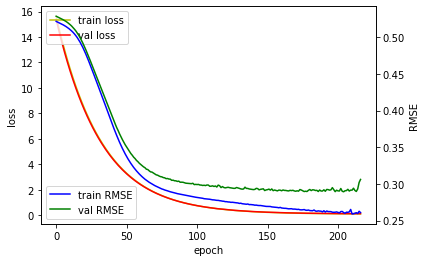

In [39]:
# Plot RMSE
plt.figure(figsize=(8,8))

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(result.history['loss'], 'y', label = 'train loss')
loss_ax.plot(result.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(result.history['root_mean_squared_error'], 'b', label = 'train RMSE')
acc_ax.plot(result.history['val_root_mean_squared_error'], 'g', label = 'val RMSE')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('RMSE')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.savefig(aa+'_model_loss.png')

In [40]:
# Prediction
user_ids = ratings_test.cust.values[100:110]
pd_ids = ratings_test.pd_c.values[100:110]
user_test = test_asz[100:110]
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu
print("Actuals: \n", ratings_test[100:110]["score"])
print()
print("Predictions: \n", predictions)

Actuals: 
 31976    2.25
18837    1.75
36300    1.50
22892    1.25
29937    2.50
5179     1.75
28160    2.00
450      2.50
11626    2.00
7571     2.25
Name: score, dtype: float64

Predictions: 
 [[2.3043702]
 [1.9549917]
 [1.5189409]
 [1.1350484]
 [2.3107493]
 [1.7112339]
 [2.069314 ]
 [2.1339216]
 [2.0148067]
 [2.3457308]]


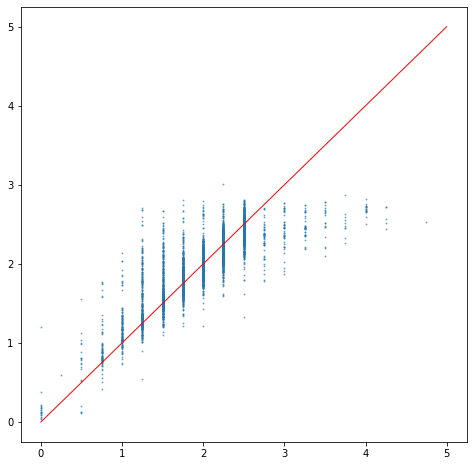

In [41]:
# Pred plot
user_ids = ratings_test.cust.values
pd_ids = ratings_test.pd_c.values
user_test = test_asz
predictions = keras_model_best.predict([user_ids, pd_ids, user_test.ages, user_test.ma_fem_dv]) + mu


plt.figure(figsize=(8,8))
plt.scatter(x = ratings_test.score, y = predictions, s=1, alpha = 0.5)
plt.plot([0, 5], [0, 5], color="red", lw=1, linestyle='solid')
plt.savefig(aa+'_test_predplot.png')

# OUTPUT file 생성

In [42]:
last["pred_score"] = keras_model_best.predict([last["cust"], last["pd_c"], last["ages"], last["ma_fem_dv"]]) + mu

In [43]:
last

,cust,pd_c,ages,ma_fem_dv,pred_score
0,0,0,30.0,1,0.818879
1,0,1,30.0,1,0.740450
2,0,2,30.0,1,1.367177
3,0,3,30.0,1,0.863620
4,0,4,30.0,1,0.889656
...,...,...,...,...,...
10642807,7699,1383,50.0,1,2.396448
10642808,7699,1384,50.0,1,2.227318
10642809,7699,1385,50.0,1,1.873677
10642810,7699,1386,50.0,1,2.493126


In [44]:
last.to_csv(aa+"_output.csv",index=False)